# Problem

In this project you must perform and explain simple linear regression using Python on the powerproduction dataset available on Moodle. The goal is to accurately pre- dict wind turbine power output from wind speed values using the data set as a basis. Your submission must be in the form of a git repository containing, at a minimum, the following items:
1. Jupyter notebook that performs simple linear regression on the data set.
2. In that notebook, an explanation of your regression and an analysis of its accuracy. 3. Standard items in a git repository such as a README.
To enhance your submission, you might consider comparing simple linear regression to other types of regression on this data set. Rest assured, all the above concepts will be explored in lecture videos and other materials in the coming semester.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
power_output_df = pd.read_csv('turbine_output.csv')

power_output_df.head()

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


In [3]:
power_output_df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


500 observations.

Minimum speed is 0, maximum is 25.0.
Median speed is 12.5. Interquartile range is also 12.5. Looks pretty evenly distributed.

Minimum output is 0. Maximum is 113.556
Median output is 41.6455. Interquartile range is around 86. Skewed a bit to the lower end.

From this can assume that the speed:output relationship is not 1:1, and that at some point output grows faster than speed. This is because the range of speeds is consistent, but the range of power values grows faster.

<AxesSubplot:xlabel='speed', ylabel='power'>

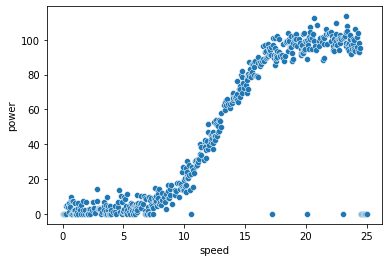

In [4]:
import seaborn as sns

ax = sns.scatterplot(x = power_output_df.speed, y = power_output_df.power)
ax

Can see the "S" shape here. SO around that midpoint where speed is rouhly 8-20 there is a clear relationship. After 20 it seems to flatten out. Perhaps this is a maximum output? Simolarlu from 0 to 8 output hovers near 0, so perhaps a minimum speed is required.

May be that cutting observations at either side yields a more accurate relationship.

<AxesSubplot:xlabel='speed', ylabel='Count'>

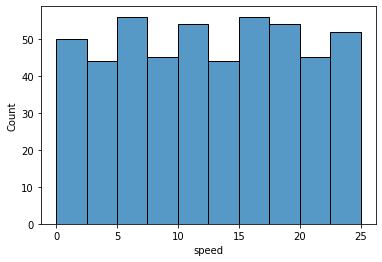

In [5]:
sns.histplot(power_output_df.speed)

Speed is pretty evenly distributed. I suspect these are just different pre-determined intervals at which to measure the output.

<AxesSubplot:xlabel='power', ylabel='Count'>

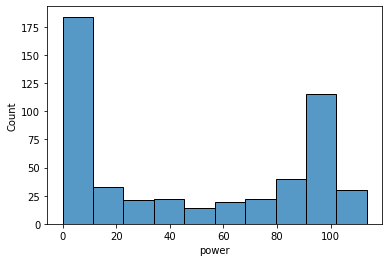

In [6]:
sns.histplot(power_output_df.power)

Sizable spike at 0, and another at 100. This might back up my early hypothesis that there's a minimum speed for output, and a maximum output regardless of additional speed.

## Fitting a line

From our exploratory data analysis, we can see that this data set is not ideally suited to fitting a line, as it has more of an S shape to it, rather than a straight linear relationship. We can see that the power generation stays close to 0 until wind speed is around 7m/s, at which point we see what looks like a linear relationship until windspeed hits 16m/s where power generation then appears to be capped at around 100.

Nonetheless, we can attempt to fit a line to this data to really highlight that there isn't a truly linear relationship between the two variables. 

### Introduce Simple Linear Regression

Simple Linear Regression, also known as univariate linear regression, is the act of using a line of best fit to highlight the relationship between a variable (x) and its result (y). In this example, we are looking at what relationship windspeed (x) has on the power output (y) for a wind turbine. This line of best fit will give the user some indication of the relationship (if any), and can help the user to predict roughly what y will be for any given value of x. This line can generally be summed up as:

y = mx + c

Where y is the result we're looking to work out. x is the variable that we know has an effect on y. m shows us the slope of the line, i.e. how quickly the y values will increase or decrease as x changes. And c is the y-intercept, that is to say, what the y value would be if x is equal to 0.

That said, it should be stressed that this line will rarely be exact, as we are trying to find the line that best sums up the relationship to the data as a whole, and so it may not match perfectly for any one pair of data points. The line is balanced between all of the data points with the aim of minimizing the overall difference between the data points and where the line is placed. This means that any outliers, positive or negative, can have a larger influence on the placing of the line. One way to describe this is to think of the line as being a piece of wood held in place by springs (the data points) above and below it. Those springs closes to the wood apply some force on it, and so they impact the angle of the slop to some degree, however the springs that are furthest away will be applying the most force to the wood and thus have the largest impact on the angle of the slope.

https://joshualoftus.com/posts/2020-11-23-least-squares-as-springs/

First let's take another look at the shape of our data.

<AxesSubplot:xlabel='speed', ylabel='power'>

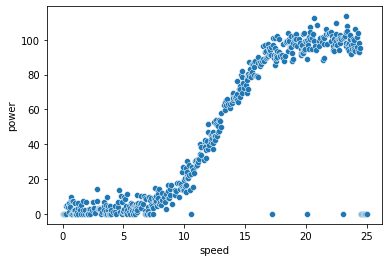

In [7]:
ax = sns.scatterplot(x = power_output_df.speed, y = power_output_df.power)
ax

Before we can fit a line to this, we'll need to work out what the slope (m) and y-intercept (c) would be. Fortunately, Numpy is able to quickly do this for us via the polyfit() function https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html.

For this, I'll just need to provide the x variable (power_output_df.speed), the y variable (power_output_df.power), and as we're looking for a line of best fit, the degree parameter will be set to 1. This polyfit() function will give us two values - the slope and the y-intercept. I can therefore assign these two outputs to two variables - m and c.

In [8]:
m,c = np.polyfit(power_output_df.speed, power_output_df.power, 1)
print("m: " + str(m))
print("c: " + str(c))

m: 4.917595665404667
c: -13.899902630519604


Now that I have m and c, I can use these two values to plot my line. On the x axis, I'll simply have the power_output_df.speed values. Meanwhile on the y axis, I'll be multiplying power_output_df.speed by m, and adding c in order to generate the corresponding y values. This replicates the y=mx+c formula discussed previsouly.

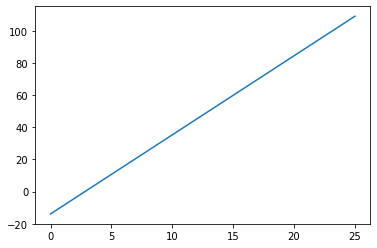

In [9]:
plt.plot(power_output_df.speed, power_output_df.speed*m + c)

We can see that the windspeed goes from 0 to 25m/s, just like our initial data set. The maximum y value is above 100, and as we know there is a value of 113 in the real data set, this could be correct. However, when x is 0, y is around -18. This can't possibly be correct, as our data set has 0 as the lowest y value. So before we've compared this line to our data, there's already question marks over how effective this line will be.

I'll now plot it alongside the data points for closer inspection.

<AxesSubplot:xlabel='speed', ylabel='power'>

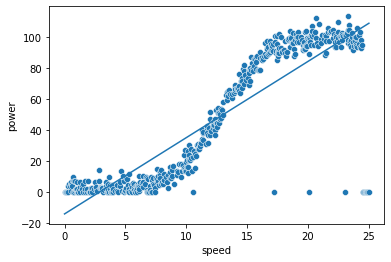

In [10]:
ax = sns.scatterplot(x = power_output_df.speed, y = power_output_df.power)
ax.plot(power_output_df.speed, power_output_df.speed*m + c)
ax

As we can see, this line might be the best fit for the data set as a whole, but it is limited in how effectively it shows the relationship between the data. We don't see the slow climb of energy generation until 7 m/s. We don't see just how quickly energy generation increases from 7m/s to 18m/s. And we don't see that power generation is capped around 100. Therefore at no point other than the midpoint (when is around 12.5) can we be confident that the y value is close to the true value. Also the fact it doesn't show that the power generation has a ceiling means that this line would keep giving higher and higher y values, even when the windspeed is at 50m/s which would lead to very misleading results.

I'll therefore need to find a way to fit a curve to this dataset, rather than a straight line. A polynomial regression will be my next step.

## Fitting a curve

Following the Pythonbasic tutoral, we can add a polynomial regression. This creates a curve that generally matches the data more accurately. However the start and end of the curve are being influenced by outliers and such.

First let's try a 3 degree polynomial regression.

In [11]:
x = power_output_df['speed']
y = power_output_df['power']

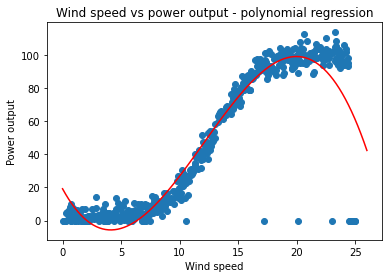

In [12]:
#https://pythonbasics.org/polynomial-regression-in-python/
poly_fit = np.poly1d(np.polyfit(x,y, 3))

xx = np.linspace(0, 26, 100)
plt.plot(xx, poly_fit(xx), c='r', linestyle='-')
plt.title('Wind speed vs power output - polynomial regression')
plt.xlabel('Wind speed')
plt.ylabel('Power output')
plt.scatter(x, y)
plt.show()

The degrees can be increase or decreased to provide different results, however the user must beware of over-fitting or under-fitting their data. Overfitting the data means that the line is matching the existing data points too closely, and so while it may look very accurate for the data points available, it may not be useful for predicting new data points. Meanwhile underfitting can lead to the predictions being incorrect most of the time - for both known data point and unknown.

For example, if we increase the degrees to 8, we can see that the line starts from 0 and begins to increase, rather than starting higher and dipping as shown in the 3 degrees plot above. However, we see that this causes the line to be massively affected by the points that show 0 power generate despite windspeeds above 24.5m/s.

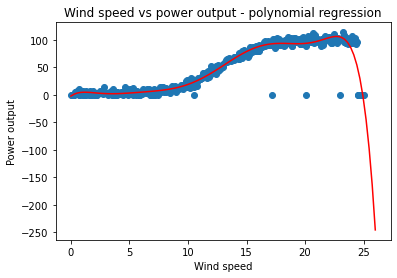

In [13]:
poly_fit = np.poly1d(np.polyfit(x,y, 8))

xx = np.linspace(0, 26, 100)
plt.plot(xx, poly_fit(xx), c='r', linestyle='-')
plt.title('Wind speed vs power output - polynomial regression')
plt.xlabel('Wind speed')
plt.ylabel('Power output')
plt.scatter(x, y)
plt.show()

Were we to remove those measurements above 24.499 m/s, we'd see that a polynomial regression with 8 degrees would line up perfectly. Even 3 degrees becomes much much closer.

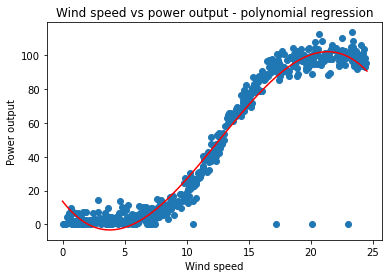

In [14]:
no_outliers = power_output_df.loc[power_output_df['speed'] < 24.499]

x2 = no_outliers['speed']
y2 = no_outliers['power']

poly_fit = np.poly1d(np.polyfit(x2,y2, 3))

xx = np.linspace(0, 24.5, 100)
plt.plot(xx, poly_fit(xx), c='r', linestyle='-')
plt.title('Wind speed vs power output - polynomial regression')
plt.xlabel('Wind speed')
plt.ylabel('Power output')
plt.scatter(x2, y2)
plt.show()

## Using SKLearn

https://www.geeksforgeeks.org/python-implementation-of-polynomial-regression/
https://towardsdatascience.com/polynomial-regression-with-scikit-learn-what-you-should-know-bed9d3296f2
https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386

In [15]:
#Getting an error as the linear regression is expecting a 2d array.
X = np.array(x).reshape(-1, 1)

In [16]:
# Fitting Linear Regression to the dataset 
from sklearn.linear_model import LinearRegression 
lin = LinearRegression() 
  
lin.fit(X, y) 

LinearRegression()

In [17]:
# Fitting Polynomial Regression to the dataset 
from sklearn.preprocessing import PolynomialFeatures 
  
poly = PolynomialFeatures(degree = 4) 
X_poly = poly.fit_transform(X) 
  
poly.fit(X_poly, y) 
lin2 = LinearRegression() 
lin2.fit(X_poly, y) 

LinearRegression()

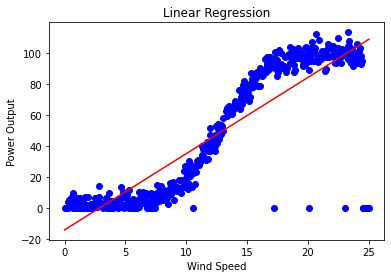

In [18]:
# Visualising the Linear Regression results 
plt.scatter(X, y, color = 'blue') 
  
plt.plot(X, lin.predict(X), color = 'red') 
plt.title('Linear Regression') 
plt.xlabel('Wind Speed') 
plt.ylabel('Power Output') 
  
plt.show() 

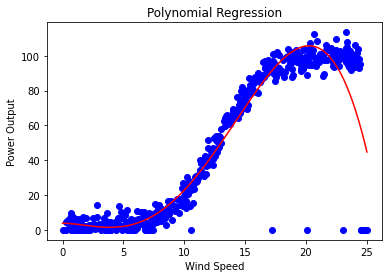

In [19]:
# Visualising the Polynomial Regression results 
plt.scatter(X, y, color = 'blue') 
  
plt.plot(X, lin2.predict(poly.fit_transform(X)), color = 'red') 
plt.title('Polynomial Regression') 
plt.xlabel('Wind Speed') 
plt.ylabel('Power Output') 
  
plt.show()

In [20]:
# Predicting a new result with Polynomial Regression 
lin2.predict(poly.fit_transform(np.array(13.0).reshape(-1,1)))

array([49.81612299])

## How does it look if we remove all 0s?

There's a few observations of 0 output, even though the observations around them have quite high output. For example:
* 17.117m/s output = 91.270
* 17.142m/s output = 95.622
* 17.167m/s output = 0.000
* 17.267m/s output = 100.831
* 17.317m/s output = 96.970

This measurement at 17.167m/s is an outlier. There's a few reasons this may have come about. It's possible that there was a malfunction that prevented the measurement being captured. It may also be that the wind speeds were pre-determined and there hasn't been an opportunity to measure the windspeed at 17.167m/s.

These measurements are impacting our regressions, so what does it look like if we remove the 0s? To do this, I will remove all the output measurements that are 0. This will mean that some genuine 0 measurements are removed, especially at the lower end of the windspeed scale, so I'll take a look at the impact this has.

In [21]:
no_zero_df = pd.read_csv('turbine_output.csv')
no_zero_df = no_zero_df.loc[no_zero_df['power'] > 0]

no_zero_x = no_zero_df['speed']
no_zero_y = no_zero_df['power']

<AxesSubplot:xlabel='speed', ylabel='power'>

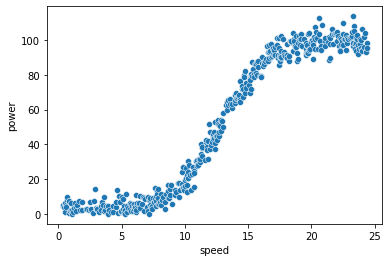

In [22]:
ax = sns.scatterplot(x = no_zero_x, y = no_zero_y)
ax

The shape of the data has remained the same, but the more obvious outliers are no longer present. I can now try the linear and polynomial regressions on this to see how it impacts the results.

<AxesSubplot:xlabel='speed', ylabel='power'>

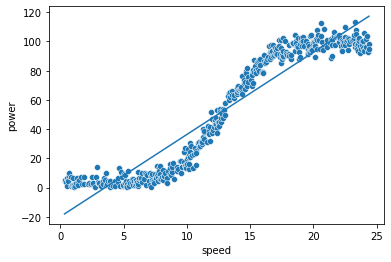

In [23]:
m,c = np.polyfit(no_zero_x, no_zero_y, 1)
ax = sns.scatterplot(x = no_zero_x, y = no_zero_y)
ax.plot(no_zero_x, no_zero_x*m + c)
ax

The Linear Regression hasn't changed much, although any measure of its accuracy will be improved by the removal of those 0 measurements.

Now to try the polynomial regression.

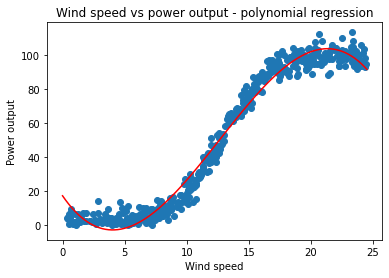

In [24]:
poly_fit = np.poly1d(np.polyfit(no_zero_x, no_zero_y, 3))

#All the measurements after 24.5 have been removed as they have a measurement of 0.
xx = np.linspace(0, 24.5, 100)
plt.plot(xx, poly_fit(xx), c='r', linestyle='-')
plt.title('Wind speed vs power output - polynomial regression')
plt.xlabel('Wind speed')
plt.ylabel('Power output')
plt.scatter(no_zero_x, no_zero_y)
plt.show()

The curve at 3 degrees fits a bit better than before, we its no longer being dragged down towards 0 after 24.5m/s

## Decision Tree Regression

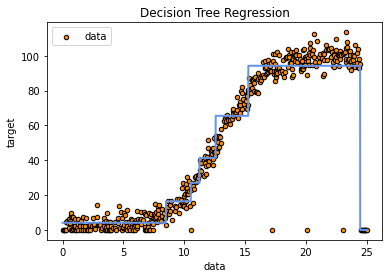

In [31]:
#https://scikit-learn.org/stable/modules/tree.html

from sklearn import tree

clf = tree.DecisionTreeRegressor(max_depth=3)
clf = clf.fit(X, y)

# Predict
X_test = np.arange(0.0, 25.0, 0.01)[:, np.newaxis]
y_est = clf.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_est, color="cornflowerblue", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

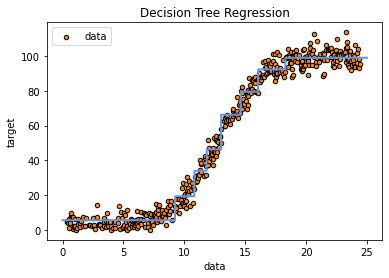

In [36]:
#same as above without the outliers
no_zero_X = np.array(no_zero_x).reshape(-1, 1)

clf = tree.DecisionTreeRegressor(max_depth=3)
clf = clf.fit(no_zero_X, no_zero_y)

# Predict
X_test = np.arange(0.0, 25.0, 0.01)[:, np.newaxis]
y_est = clf.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(no_zero_X, no_zero_y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_est, color="cornflowerblue", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

[Text(193.15384615384616, 190.26, 'X[0] <= 12.576\nmse = 1728.309\nsamples = 500\nvalue = 48.015'),
 Text(103.01538461538462, 135.9, 'X[0] <= 10.536\nmse = 175.71\nsamples = 251\nvalue = 11.475'),
 Text(51.50769230769231, 81.53999999999999, 'X[0] <= 8.496\nmse = 40.901\nsamples = 209\nvalue = 6.357'),
 Text(25.753846153846155, 27.180000000000007, 'mse = 13.571\nsamples = 171\nvalue = 4.117'),
 Text(77.26153846153846, 27.180000000000007, 'mse = 39.71\nsamples = 38\nvalue = 16.437'),
 Text(154.52307692307693, 81.53999999999999, 'X[0] <= 11.249\nmse = 67.586\nsamples = 42\nvalue = 36.943'),
 Text(128.76923076923077, 27.180000000000007, 'mse = 18.591\nsamples = 13\nvalue = 27.109'),
 Text(180.27692307692308, 27.180000000000007, 'mse = 26.767\nsamples = 29\nvalue = 41.351'),
 Text(283.2923076923077, 135.9, 'X[0] <= 24.449\nmse = 590.82\nsamples = 249\nvalue = 84.848'),
 Text(257.53846153846155, 81.53999999999999, 'X[0] <= 15.253\nmse = 301.718\nsamples = 239\nvalue = 88.398'),
 Text(231.784

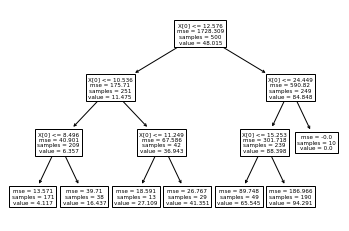

In [26]:
tree.plot_tree(clf) 

## K Nearest Neighbors Regression

### Uniform

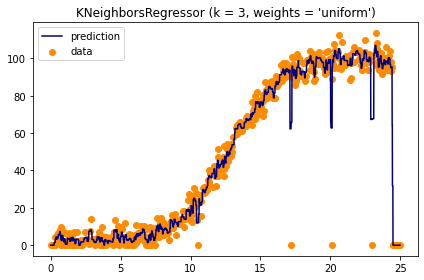

In [47]:
#https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html#sphx-glr-auto-examples-neighbors-plot-regression-py

from sklearn import neighbors

n_neighbors = 3

knn = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')
y_knn = knn.fit(X, y).predict(X_test)

plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X_test, y_knn, color='navy', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                'uniform'))

plt.tight_layout()
plt.show()



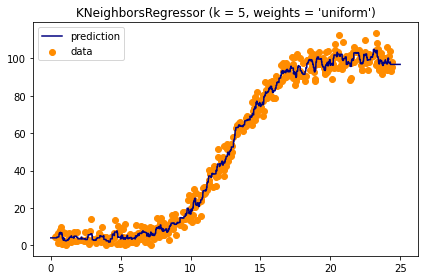

In [46]:
#same as above without outliers

n_neighbors = 5

knn = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')
y_knn = knn.fit(no_zero_X, no_zero_y).predict(X_test)

plt.scatter(no_zero_X, no_zero_y, color='darkorange', label='data')
plt.plot(X_test, y_knn, color='navy', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                'uniform'))

plt.tight_layout()
plt.show()

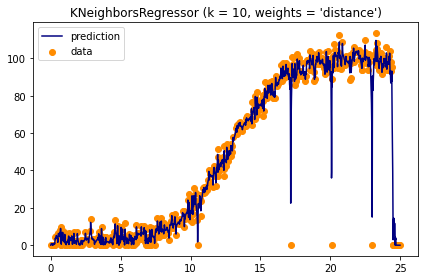

In [28]:
n_neighbors = 10

knn = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')
y_knn = knn.fit(X, y).predict(X_test)

plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X_test, y_knn, color='navy', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                'distance'))

plt.tight_layout()
plt.show()

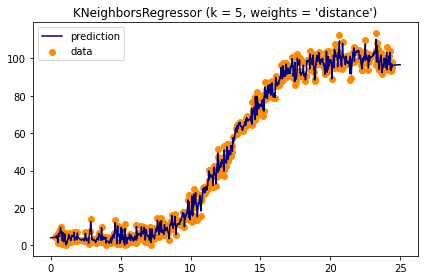

In [49]:
n_neighbors = 5

knn = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')
y_knn = knn.fit(no_zero_X, no_zero_y).predict(X_test)

plt.scatter(no_zero_X, no_zero_y, color='darkorange', label='data')
plt.plot(X_test, y_knn, color='navy', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                'distance'))

plt.tight_layout()
plt.show()